# New Experiments using the Lower / upper bounds

What kind of question would we like to answer ... 

 - What is the maximum and minimum error we get from the first lower bound compared with the final latency ?

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def openLog(filename):
    toIntList = lambda x: [int(y) for y in x.strip("[]").split(",")]
    df = pd.read_csv(filename, sep=";",
                     converters={
                         "ExpansionVertex": toIntList,
                         "ExpansionEdges": toIntList,
                         "LowerBounds": toIntList,
                         "UpperBounds": toIntList,
                     }
                    )


    df.LowerBounds = df.apply(lambda x :  [y/x.AgeLatency for y in x.LowerBounds]  , axis = 1)
    df.UpperBounds = df.apply(lambda x :  [y/x.AgeLatency for y in x.UpperBounds]  , axis = 1)
    df.ExpansionVertex = df.apply(lambda x :  [y/(x.sum_n+2) for y in x.ExpansionVertex]  , axis = 1)

    assert(df.ExpansionVertex.apply(max).max())
    assert(df.LowerBounds.apply(max).max())
    assert(df.UpperBounds.apply(max).max())

    df["BoundsDistances"] = df.apply(lambda x : [abs( l - r ) for (l,r) in zip(x.LowerBounds,x.UpperBounds)], axis=1)
    df["bounds_shift"] = df.apply ( lambda x : (x["LowerBounds"].index(1) - x["UpperBounds"].index(1)) if x["LowerBounds"].count(1) else None , axis=1)
    df["early_bounds"] = df.apply ( lambda x : ((x["LowerBounds"].index(1) + 1< len(x["LowerBounds"])) and  (x["UpperBounds"].index(1) + 1 < len(x["UpperBounds"]) ))  if x["LowerBounds"].count(1) else None , axis=1)
    df["filename"] = filename
    
    return df.reset_index()

df = openLog("automotive.test.log")

In [136]:
def openLogs(filelist):
    df = None
    for f in filelist:
        df = pd.concat([df,openLog(f)], ignore_index=True)
    return df
df = openLogs(["automotive.csv", "automotivediti.csv","harmonic.csv","harmonicditi.csv"])

##  What is the maximum and minimum error we get from the first lower bound compared 

with the final latency ?

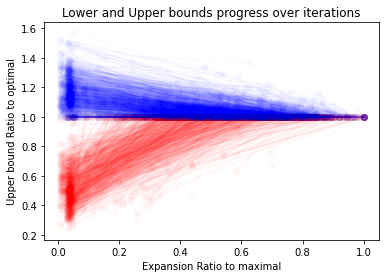

In [137]:
def lower_upper_detailled (df, alpha = None) :
    if not alpha :
        alpha = max ( 0.02,  1.0 / len(df) )
    for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.LowerBounds)  , axis = 1)) :
        plt.plot(x,y, marker="o", color = "r", alpha = alpha)
    for (x,y) in list(df.apply(lambda x :  (x.ExpansionVertex, x.UpperBounds)  , axis = 1)) :
        plt.plot(x,y, marker="o", color = "b", alpha = alpha)
    _ = plt.xlabel("Expansion Ratio to maximal")
    _ = plt.ylabel("Upper bound Ratio to optimal")
    _ = plt.title("Lower and Upper bounds progress over iterations")
lower_upper_detailled (df)

In [138]:
print(df.columns)
print(df.IterationCount.max())

Index(['index', 'kind', 'n', 'm', 'sum_n', 'AgeLatency', 'IterationCount',
       'ExpansionVertex', 'ExpansionEdges', 'LowerBounds', 'UpperBounds',
       'gen_time', 'sp_time', 'BoundsDistances', 'bounds_shift',
       'early_bounds', 'filename'],
      dtype='object')
13


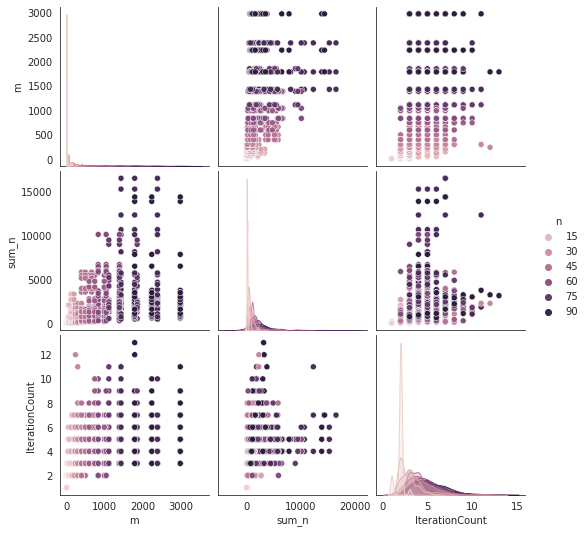

In [139]:
import seaborn as sns

def summarizePlots(df) :
    with sns.axes_style('white'):
        #_ = sns.jointplot("n", "m", data=df, kind='hex')
        _ = sns.pairplot(data=df[[ "n","m",  "sum_n", "IterationCount"]], hue="n")
summarizePlots(df)

## Study of the bounds

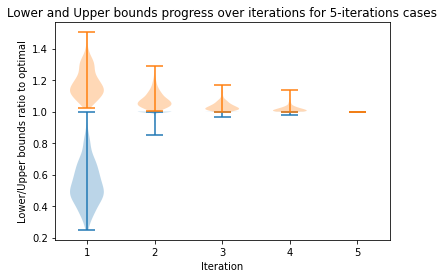

In [140]:
def plotBoundsByIteration(df, itercount) :
    sdf  =  df[df.IterationCount == itercount]
    _ = plt.violinplot(pd.DataFrame(sdf.LowerBounds.to_list(), columns=range(itercount)))
    _ = plt.violinplot(pd.DataFrame(sdf.UpperBounds.to_list(), columns=range(itercount)))
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Lower/Upper bounds ratio to optimal")
    
plotBoundsByIteration(df, 5)
_ = plt.title("Lower and Upper bounds progress over iterations for 5-iterations cases")

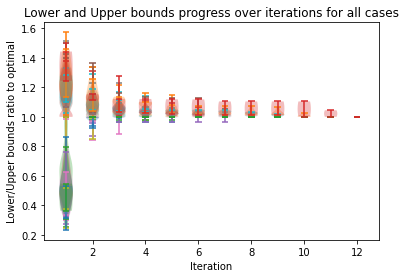

In [141]:
for it in range(1,df.IterationCount.max() + 1) :
    if len(df[df.IterationCount == it]) > 1:
        plotBoundsByIteration(df, it)
_ = plt.title("Lower and Upper bounds progress over iterations for all cases")

In [142]:
def plotBounds(df) :
    sdf = df.copy()
    sdf.LowerBounds = sdf.apply (lambda x : x.LowerBounds + (df.IterationCount.max() - x.IterationCount)*x.LowerBounds[-1:], axis = 1)
    sdf.UpperBounds = sdf.apply (lambda x : x.UpperBounds + (df.IterationCount.max() - x.IterationCount)*x.UpperBounds[-1:], axis = 1)
    _ = plt.violinplot(pd.DataFrame(sdf.LowerBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.violinplot(pd.DataFrame(sdf.UpperBounds.to_list(), columns=range(df.IterationCount.max())))
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Lower/Upper bounds ratio to optimal")
    _ = plt.title("Lower and Upper bounds progress over iterations for all cases")

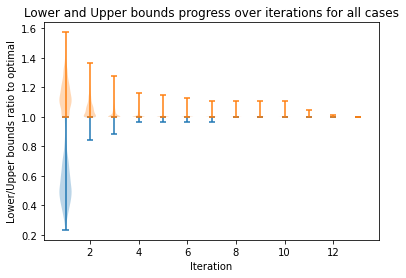

In [143]:
plotBounds(df) 

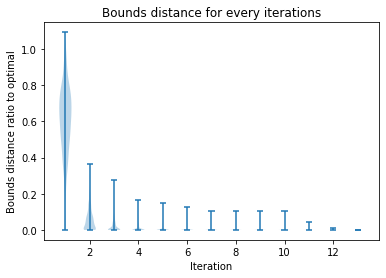

In [144]:
def plotBoundsDistances(df) :
    sdf = df.copy()
    sdf.BoundsDistances = sdf.apply (lambda x : x.BoundsDistances + (sdf.IterationCount.max() - x.IterationCount)*x.BoundsDistances[-1:], axis = 1)
    _ = plt.violinplot(pd.DataFrame(sdf.BoundsDistances.to_list(), columns=range(sdf.IterationCount.max())))
    _ = plt.title("Bounds distance for every iterations")
    _ = plt.xlabel("Iteration")
    _ = plt.ylabel("Bounds distance ratio to optimal")
plotBoundsDistances(df)

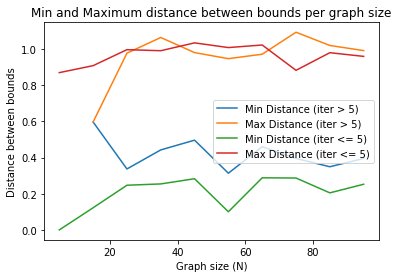

In [145]:
def plotMinMaxBoundDistance (df, label1 = "Minimal distance", label2 = "Maximal distance") :
    sdf = df.copy()
    sdf.BoundsDistances = sdf.apply (lambda x : x.BoundsDistances + (sdf.IterationCount.max() - x.IterationCount)*x.BoundsDistances[-1:], axis = 1)
    sdf["BoundsDistancesMax"] = sdf.BoundsDistances.apply(lambda x : max(x))

    x = sdf.groupby("n").max().reset_index()["n"]
    y1 = sdf.groupby("n").min().reset_index()["BoundsDistancesMax"]
    y2 = sdf.groupby("n").max().reset_index()["BoundsDistancesMax"]

    _ = plt.plot(x,y1,  label = label1)
    _ = plt.plot(x,y2,  label = label2)
    _ = plt.title("Min and Maximum distance between bounds per graph size")
    _ = plt.xlabel("Graph size (N)")
    _ = plt.ylabel("Distance between bounds")
    _ = plt.legend()
plotMinMaxBoundDistance(df[df.IterationCount > 5], label1="Min Distance (iter > 5)", label2="Max Distance (iter > 5)")
plotMinMaxBoundDistance(df[df.IterationCount <= 5], label1="Min Distance (iter <= 5)", label2="Max Distance (iter <= 5)")

In [146]:

import seaborn as sns
    
def plotData(filename) :
    fig, axes = plt.subplots(3,2,figsize=(10,10))
    fig.suptitle(f'Summary from {filename}')
    _df = openLog(filename)
    plt.sca(axes[0,0])
    plotBounds(_df)
    plt.sca(axes[1,0])
    plotBoundsDistances(_df)
    plt.sca(axes[0,1])
    lower_upper_detailled(_df)
    plt.sca(axes[1,1])
    plotMinMaxBoundDistance(_df)
    plt.sca(axes[2,0])
    df["bounds_shift"].hist()
    plt.tight_layout()
    summarizePlots(_df)
    _ = df[[ "n","m",  "sum_n", "IterationCount"]].hist()
    

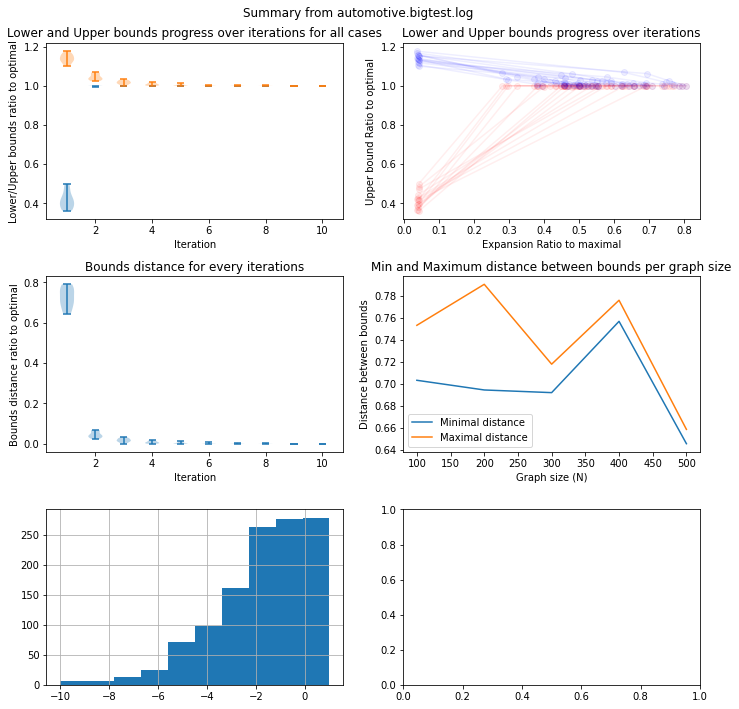

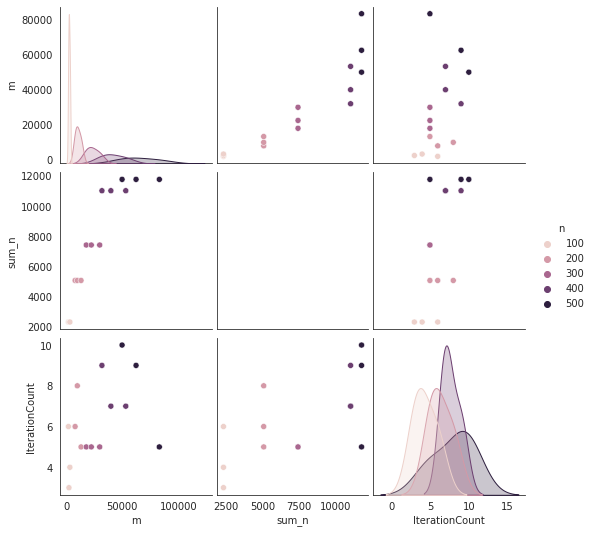

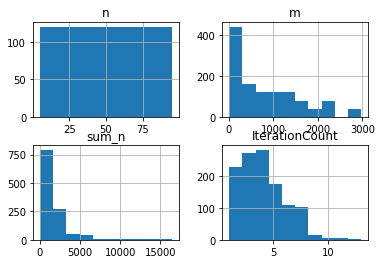

In [147]:
plotData("automotive.bigtest.log")

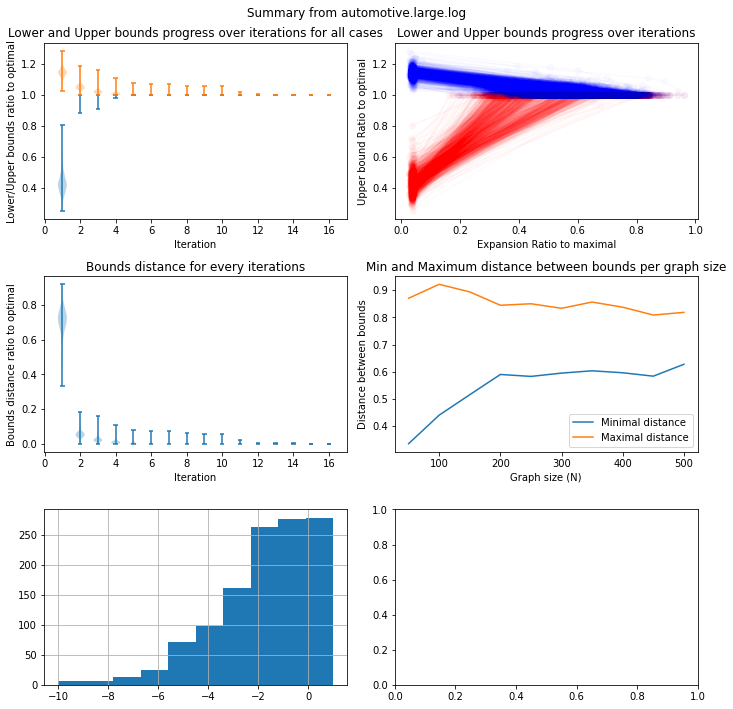

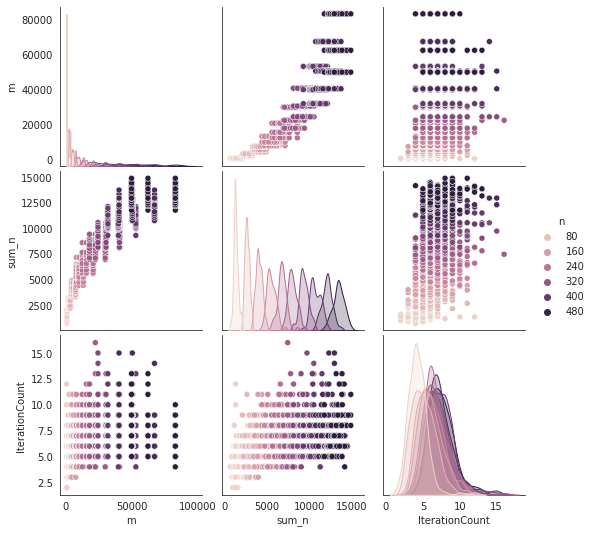

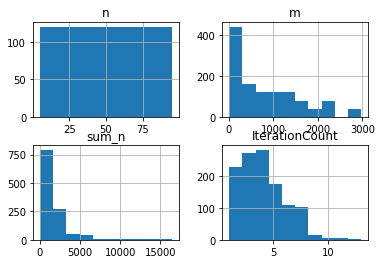

In [148]:
plotData("automotive.large.log")

# Most recent changes

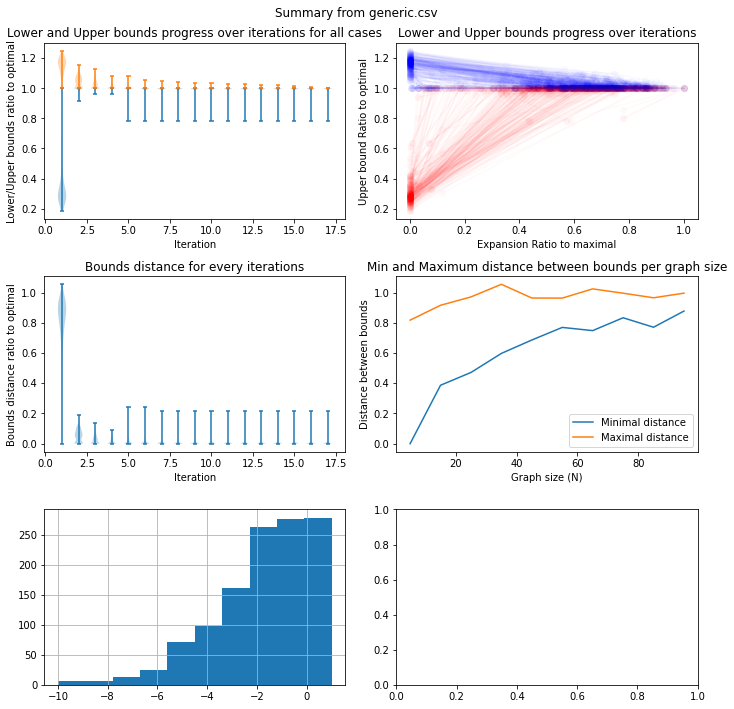

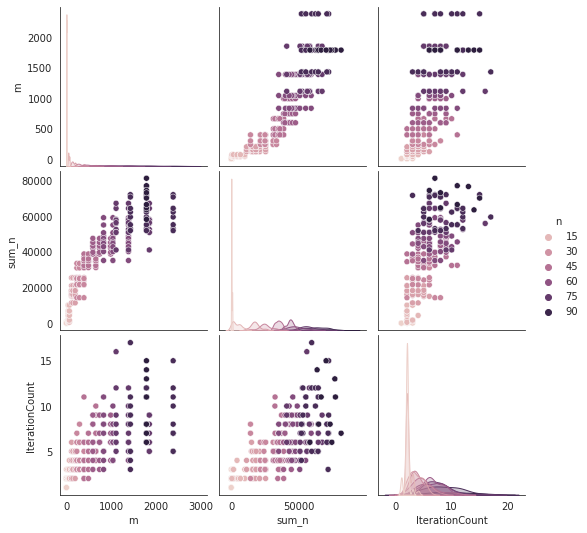

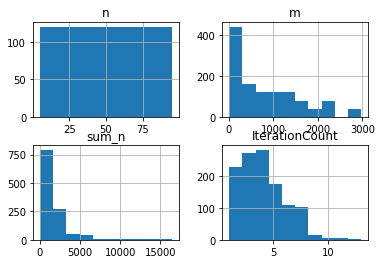

In [149]:
plotData("generic.csv")

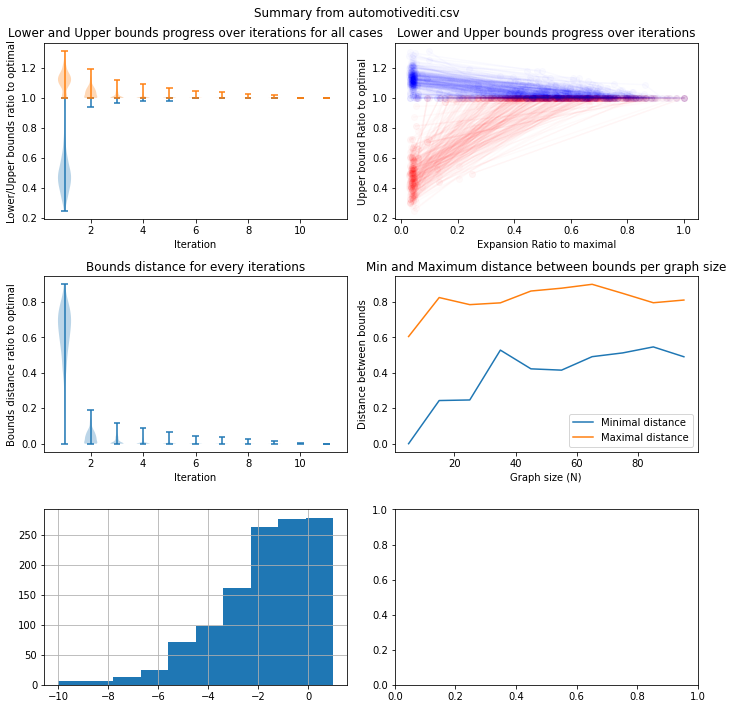

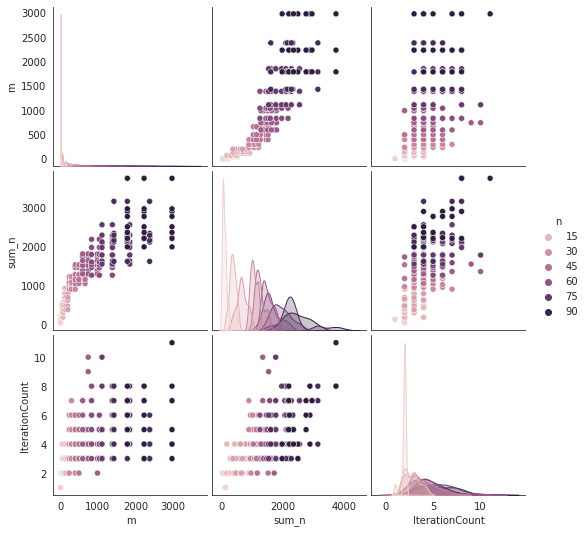

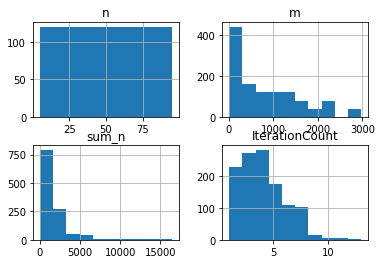

In [150]:
plotData("automotivediti.csv")

# Strange behaviour for generic

In [157]:
generic_df = openLog("generic.csv")
generic_df[generic_df["bounds_shift"].isna()]

,index,kind,n,m,sum_n,AgeLatency,IterationCount,ExpansionVertex,ExpansionEdges,LowerBounds,UpperBounds,gen_time,sp_time,BoundsDistances,bounds_shift,early_bounds,filename
108,108,1,35,297,14246,115,8,"[0.0025968556990454803, 0.2674059517125211, 0....","[302, 42421, 45449, 46858, 48486, 92475, 92826...","[0.3217391304347826, 0.991304347826087, 0.9913...","[1.2, 1.0782608695652174, 1.0695652173913044, ...",1353.0,834.0,"[0.8782608695652174, 0.08695652173913038, 0.07...",NaN,None,generic.csv


In [166]:
generic_df = openLog("../seek.csv")
generic_df[generic_df["bounds_shift"].isna()]

,index,seed,kind,DiEqTi,n,m,sum_n,AgeLatency,IterationCount,ExpansionVertex,ExpansionEdges,LowerBounds,UpperBounds,gen_time,sp_time,BoundsDistances,bounds_shift,early_bounds,filename
10685,10685,812,1,0,4,3,243,16,3,"[0.024489795918367346, 0.18775510204081633, 0....","[6, 79, 166]","[0.5, 0.9375, 0.5]","[1.0, 1.0, 1.0]",0.0,0.0,"[0.5, 0.0625, 0.5]",NaN,None,../seek.csv
11752,11752,1879,1,0,4,3,61,14,3,"[0.09523809523809523, 0.15873015873015872, 0.4...","[6, 13, 54]","[0.5714285714285714, 0.7857142857142857, 0.714...","[1.0714285714285714, 1.0, 1.0]",0.0,0.0,"[0.5, 0.2142857142857143, 0.2857142857142857]",NaN,None,../seek.csv
13366,13366,3493,1,0,4,3,15,15,2,"[0.35294117647058826, 0.9411764705882353]","[6, 23]","[0.6666666666666666, 0.7333333333333333]","[1.0, 1.0]",0.0,0.0,"[0.33333333333333337, 0.2666666666666667]",NaN,None,../seek.csv
13511,13511,3638,1,0,4,3,79,19,3,"[0.07407407407407407, 0.2345679012345679, 0.39...","[6, 30, 62]","[0.42105263157894735, 0.8947368421052632, 0.89...","[1.3157894736842106, 1.0, 1.0]",0.0,0.0,"[0.8947368421052633, 0.10526315789473684, 0.10...",NaN,None,../seek.csv
14765,14765,4892,1,0,4,3,211,18,3,"[0.028169014084507043, 0.13145539906103287, 0....","[6, 42, 124]","[0.3333333333333333, 0.8888888888888888, 0.5]","[1.0, 1.0, 1.0]",0.0,0.0,"[0.6666666666666667, 0.11111111111111116, 0.5]",NaN,None,../seek.csv
16600,16600,6727,1,0,4,3,201,17,3,"[0.029556650246305417, 0.12807881773399016, 0....","[6, 39, 137]","[0.47058823529411764, 0.9411764705882353, 0.47...","[1.1176470588235294, 1.0, 1.0]",0.0,0.0,"[0.6470588235294118, 0.05882352941176472, 0.52...",NaN,None,../seek.csv
16716,16716,6843,1,0,4,3,106,12,3,"[0.05555555555555555, 0.14814814814814814, 0.4...","[6, 26, 118]","[0.5, 0.8333333333333334, 0.5]","[1.0, 1.0, 1.0]",0.0,0.0,"[0.5, 0.16666666666666663, 0.5]",NaN,None,../seek.csv
16779,16779,6906,1,0,4,3,163,19,3,"[0.03636363636363636, 0.13333333333333333, 0.8]","[6, 40, 270]","[0.47368421052631576, 0.8421052631578947, 0.36...","[1.0526315789473684, 1.0, 1.0]",0.0,0.0,"[0.5789473684210527, 0.1578947368421053, 0.631...",NaN,None,../seek.csv
18161,18161,8288,1,0,4,3,41,14,3,"[0.13953488372093023, 0.23255813953488372, 0.4...","[6, 13, 39]","[0.5714285714285714, 0.9285714285714286, 0.857...","[1.2142857142857142, 1.0, 1.0]",0.0,0.0,"[0.6428571428571428, 0.0714285714285714, 0.142...",NaN,None,../seek.csv
18250,18250,8377,1,0,4,3,190,14,3,"[0.03125, 0.109375, 0.4166666666666667]","[6, 36, 207]","[0.42857142857142855, 0.8571428571428571, 0.57...","[1.0714285714285714, 1.0, 1.0]",0.0,0.0,"[0.6428571428571428, 0.1428571428571429, 0.428...",NaN,None,../seek.csv


In [165]:
!head ../seek.csv

seed;kind;DiEqTi;n;m;sum_n;AgeLatency;IterationCount;ExpansionVertex;ExpansionEdges;LowerBounds;UpperBounds;gen_time;sp_time
127;1;0;4;2;82;11;2;"[6,16]";"[7,27]";"[5,11]";"[11,11]";0.00;0.00
128;1;0;4;2;53;14;2;"[6,21]";"[7,37]";"[6,14]";"[14,14]";0.00;0.00
129;1;0;4;2;44;11;2;"[6,15]";"[7,25]";"[8,11]";"[11,11]";0.00;0.00
130;1;0;4;2;47;12;2;"[6,18]";"[7,35]";"[7,12]";"[12,12]";0.00;0.00
131;1;0;4;2;241;21;2;"[6,19]";"[7,34]";"[14,21]";"[21,21]";0.00;0.00
132;1;0;4;2;157;13;2;"[6,18]";"[6,30]";"[7,13]";"[13,13]";0.00;0.00
133;1;0;4;2;83;20;2;"[6,12]";"[6,16]";"[16,20]";"[20,20]";0.00;0.00
134;1;0;4;2;277;11;2;"[6,15]";"[7,25]";"[7,11]";"[11,11]";0.00;0.00
135;1;0;4;2;5;4;2;"[6,7]";"[7,9]";"[4,4]";"[4,4]";0.00;0.00
